### 1. Environment set-up

In [ ]:
import sys

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4k9sdcev
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4k9sdcev
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=6972556521b875ce349ed73a869262b4e778e2560665cafa27c65a97ee67a6d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-j9yjrnd9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-03-28 17:04:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.70, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227

In [ ]:
%pip install -q roboflow supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Set-up

In [ ]:
import torch
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import supervision as sv
import tensorflow as tf
import keras.backend as K

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
def calculate_results(results):
  iou_pred = np.array([
      iou_pred['predicted_iou']
      for iou_pred in results
  ])

  pred = iou_pred.mean()

  return pred

### 3. Show exemple image

In [ ]:
path = '/content/drive/MyDrive/fine tune sam/dataset/crack_detection_224_images'
dataset = os.listdir(path)
images = []

for paths in sorted(dataset):

  image_bgr = cv2.imread(f'/content/drive/MyDrive/fine tune sam/dataset/crack_detection_224_images/{paths}')

  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

  data = {'name': paths,
        'bgr': image_bgr,
        'rgb': image_rgb}

  images.append(data)

In [ ]:
print(f"O dataset contém {len(images)} imagens.")

O dataset contém 240 imagens.


In [ ]:
images[0]['name']

'a_0_10.png'

In [ ]:
image = cv2.imread(path + '/' + images[0]['name'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

[]

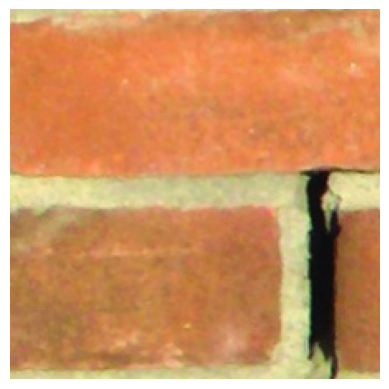

In [ ]:
plt.imshow(image)
plt.axis('off')

plt.plot()

### 4. Automatic mask generation

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
)

In [ ]:
annotaded_images = []
iou = np.array([])
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)


output = len(os.listdir('/content/drive/MyDrive/fine tune sam/output'))
print(f"A pasta de Output possui {output} imagens")

for image in images:

    sam_result = mask_generator.generate(image['rgb'])
    iou_pred = calculate_results(sam_result)
    iou = np.append(iou, iou_pred)

    detections = sv.Detections.from_sam(sam_result=sam_result)
    annotaded_image = mask_annotator.annotate(scene=image['bgr'], detections=detections)

    # salvando a imagem
    cv2.imwrite(f'/content/drive/MyDrive/fine tune sam/outputs/Negative/{(image["name"])}', annotaded_image)

    annotaded_images.append(annotaded_image)

print(f'Foram gerados {len(annotaded_images)} resultados')

In [ ]:
print(iou.mean())

0.941399655564517
